---
* Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

---
* Codon Table 
* Translation Function
* Motif

In [ ]:
# aa codon table
codon_dic_updated = {
                'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
                'TCT': "S'", 'TCC': "S'", 'TCA': "S'", 'TCG': "S'",
                'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',  # * for STOP
                'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',

                'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
                'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
                'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
                'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',

                'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
                'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
                'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
                'AGT': 'S"', 'AGC': 'S"', 'AGA': 'R', 'AGG': 'R',

                'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
                'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
                'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
                'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
                }

aa_list = ["F", "L", "S'", "Y", "*", 
           "C", "W", "P", "H", "Q", 
           "R", "I", "M", "T", "N", 
           "K", 'S"', "R", "V", "A", 
           "D", "E", "G"]

# Translating nt sequence
def nt_transalte_104(nt_seq):
    rem3 = len(nt_seq) % 3

    if rem3 != 0:
        nt_seq = nt_seq[:-rem3]

    translated = []
    seq_len = len(nt_seq)

    for i in range(1, int((seq_len+3)/3)):
        codon = nt_seq[i*3-3:i*3]
    
        if codon in list(codon_dic_updated.keys()):
            aa = codon_dic_updated[codon]  
        else:
            aa = "-"
            
        translated.append(aa)
    
    return translated

In [3]:
# Found motif (part of the)
motif_list = ["V", "A", "V", "I", "S'", "Y", "D", "-", "-", 'G', 'S"', "N", "K", "Y"]
motif_array = np.array(motif_list)
motif_str = "".join(motif_list)

In [4]:
dropped_labels = [("sp")]

---
* Creating motif object
* Importing sequences dataset to python
* Cleaning the data (renaming values in ab_target and time_point columns)

In [5]:
# Importing sequence dataset
cl_seqs = pd.read_csv("trimers_processed_tables\\cleaned_seqs.csv", index_col=0)

# Changing the metadata values
cl_seqs["time_point"] = cl_seqs["time_point"].apply(lambda X : X[0])
cl_seqs["ab_target"] = cl_seqs["ab_target"].map({"Non-Spike B":"sn", "Spike+ Mem B":"sp"})
cl_seqs["subject_id"] = "subj_" + cl_seqs.subject_id.astype("str")
cl_seqs = cl_seqs[["clone_id", "sequence", "germline", "copy_number", "subject_id", "ab_target", "time_point"]]

# Getting the top sequence rows only
idx = cl_seqs.groupby('clone_id')['copy_number'].idxmax()
cl_seqs = cl_seqs.loc[idx,:]

# Translating both germline and top sequence to amino acids
# cl_seqs["germ_aa"] = cl_seqs["germline"].apply(lambda X : "".join(nt_transalte_104(X)))
# cl_seqs["seq_aa"] = cl_seqs["sequence"].apply(lambda X : "".join(nt_transalte_104(X)))
cl_seqs["germ_aa"] = cl_seqs["germline"].apply(lambda X : np.array(nt_transalte_104(X)))
cl_seqs["seq_aa"] = cl_seqs["sequence"].apply(lambda X : np.array(nt_transalte_104(X)))

# Getting the relevent motif aa sequence (54-66): VAV ISYD..GSNK Y
cl_seqs["germ_5366"] = cl_seqs["germ_aa"].apply(lambda X : X[52:66])
cl_seqs["seq_5366"] = cl_seqs["seq_aa"].apply(lambda X : X[52:66])

# Final cleanup
cl_seqs = cl_seqs[["clone_id", "germ_aa", "seq_aa", "germ_5366", "seq_5366", "subject_id", "ab_target", "time_point"]]

# Adding labels per seq
cl_seqs["label_s"] = cl_seqs.ab_target + "." + cl_seqs.time_point.astype("str")
cl_seqs["label_l"] = cl_seqs["label_s"] + "." + cl_seqs.subject_id.astype("str")

# Dropping labels filtered out in the previous analysis
filt_labels = ["sp.1.subj_7", "sp.2.subj_7", "sp.4.subj_4"]
cl_seqs = cl_seqs[cl_seqs.label_l.isin(filt_labels) == False]


---

In [6]:
# If germ / seq is the motif equal to 1
# can compare arrays with np.array_equal()
cl_seqs[["germ_motif", "seq_motif"]] = 0,0 
cl_seqs.loc[(cl_seqs["germ_5366"].apply(lambda X : "".join(X) == motif_str)), "germ_motif"] = 1
cl_seqs.loc[(cl_seqs["seq_5366"].apply(lambda X : "".join(X) == motif_str)), "seq_motif"] = 1
cl_seqs.loc[(cl_seqs["seq_5366"].apply(lambda X : sum(X == motif_list) > 0.8*len(motif_list))), "seq_motif_80p"] = 1


# How many amino acids are equal compared to the motif (not including spacers)
cl_seqs["germ_neq"] = cl_seqs["germ_5366"].apply(lambda X : sum(X == motif_array) - list(X).count("-"))
cl_seqs["seq_neq"] = cl_seqs["seq_5366"].apply(lambda X : sum(X == motif_array)- list(X).count("-"))

# Diffrence between number of motif amino acids in germline compared to top sequence
cl_seqs["motif_diff"] = cl_seqs.germ_neq - cl_seqs.seq_neq

In [7]:
cl_seqs.groupby("label_s").agg({"germ_motif":lambda X : X.sum()/len(X)})

,germ_motif
label_s,
sn.1,0.069653
sn.2,0.068842
sn.4,0.070132
sp.1,0.218384
sp.2,0.163751
sp.4,0.138104


----

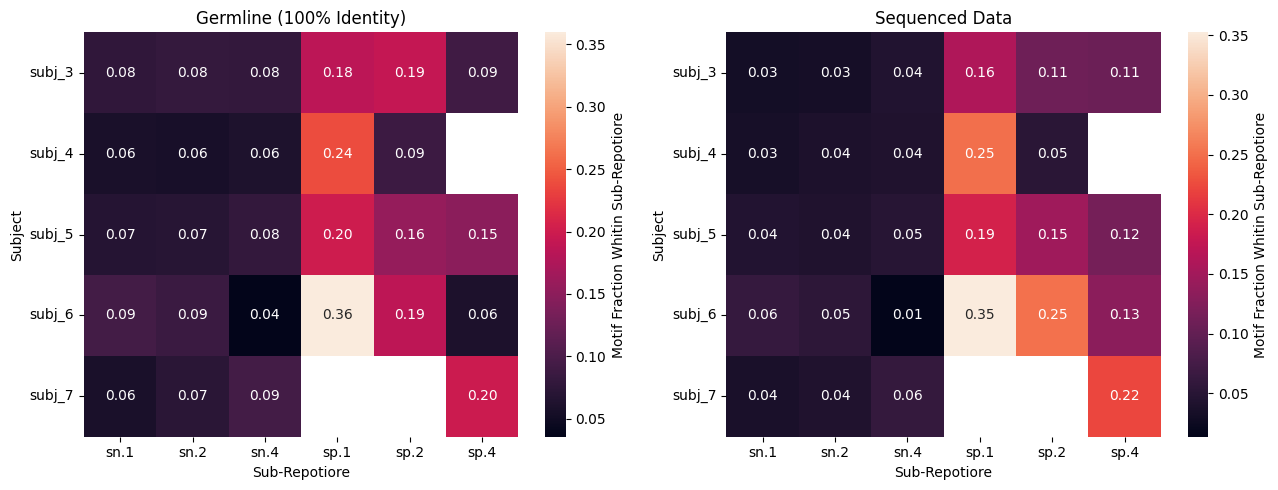

In [8]:
label_dict = {"germ":"Germline (100% Identity)", "seq":"Sequenced Data"}

fig, axs = plt.subplots(1, 2, figsize=(13,5))

for i,j in zip(["germ_motif","seq_motif_80p"], (0,1)):
    source = i
    ax = axs[j]

    unique_subjects, unique_labels = cl_seqs.subject_id.unique(), cl_seqs.label_s.unique()
    result_freqs = pd.DataFrame(index=unique_subjects, columns= unique_labels)
    conditions = [(i,j) for i in np.sort(unique_subjects) for j in np.sort(unique_labels)]

    for cnd in conditions:
        temp_ser =  cl_seqs.loc[(cl_seqs.subject_id == cnd[0]) & (cl_seqs.label_s == cnd[1]), source]
        if len(temp_ser) == 0:
            result_freqs.loc[cnd[0], cnd[1]] = np.nan
        
        else:
            result_freqs.loc[cnd[0], cnd[1]] = temp_ser.sum()/len(temp_ser)


    result_freqs = result_freqs.astype("float")[np.sort(result_freqs.columns)]

    sns.heatmap(result_freqs, 
                ax=ax, 
                cbar_kws={'label': 'Motif Fraction Whitin Sub-Repotiore'},
                annot=True,
                fmt='.2f')
    ax.set_title(label_dict[i.split("_")[0]])
    ax.tick_params(axis='y', labelrotation=0)
    ax.set_xlabel("Sub-Repotiore")
    ax.set_ylabel("Subject")

plt.tight_layout()
plt.show()


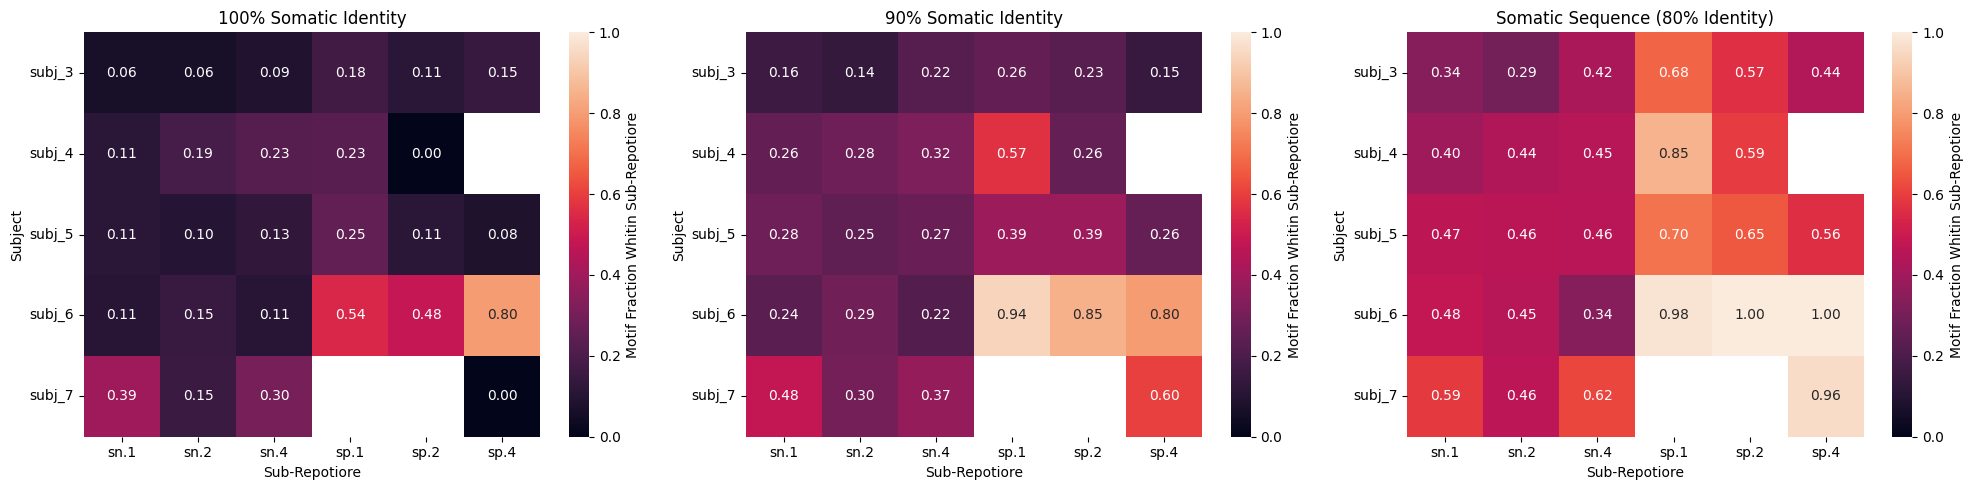

In [9]:
only_germ_motif = cl_seqs.copy()[cl_seqs.germ_motif == 1]
only_germ_motif.loc[(only_germ_motif["seq_5366"].apply(lambda X : sum(X == motif_list) > 0.9*len(motif_list))), "seq_motif_90p"] = 1

label_dict = {"seq_motif":"100% Somatic Identity", 
              "seq_motif_90p":"90% Somatic Identity",
              "seq_motif_80p":"Somatic Sequence (80% Identity)"}

fig, axs = plt.subplots(1, 3, figsize=(20,5))

for i,j in zip(["seq_motif","seq_motif_90p","seq_motif_80p"], (0,1,2)):
    source = i
    ax = axs[j]

    unique_subjects, unique_labels = only_germ_motif.subject_id.unique(), only_germ_motif.label_s.unique()
    result_freqs = pd.DataFrame(index=unique_subjects, columns= unique_labels)
    conditions = [(i,j) for i in np.sort(unique_subjects) for j in np.sort(unique_labels)]

    for cnd in conditions:
        temp_ser =  only_germ_motif.loc[(only_germ_motif.subject_id == cnd[0]) & (only_germ_motif.label_s == cnd[1]), source]
        if len(temp_ser) == 0:
            result_freqs.loc[cnd[0], cnd[1]] = np.nan
        
        else:
            result_freqs.loc[cnd[0], cnd[1]] = temp_ser.sum()/len(temp_ser)

    result_freqs = result_freqs.astype("float")[np.sort(result_freqs.columns)]

    sns.heatmap(result_freqs,
                vmin=0,
                vmax=1, 
                ax=ax, 
                cbar_kws={'label': 'Motif Fraction Whitin Sub-Repotiore'},
                annot=True,
                fmt='.2f')
    
    ax.set_title(label_dict[i])
    ax.tick_params(axis='y', labelrotation=0)
    ax.set_xlabel("Sub-Repotiore")
    ax.set_ylabel("Subject")

plt.tight_layout()
plt.show()

In [38]:
import logomaker

aa_list = ["F", "L", "S'", "Y", "*", 
           "C", "W", "P", "H", "Q", 
           "R", "I", "M", "T", "N", 
           "K", 'S"', "R", "V", "A", 
           "D", "E", "G"]

scaff_df = pd.DataFrame(index=range(53,67), columns =aa_list)
scaff_df.index.name = "pos"

In [45]:
for i in range(0, scaff_df.shape[0]):
    temp = cl_seqs.seq_5366.apply(lambda X : X[i]).value_counts()
    print(temp/temp.sum().T)

seq_5366
V     0.472625
I     0.243450
M     0.190086
L     0.078382
-     0.009531
W     0.001722
A     0.001095
E     0.001022
G     0.000628
F     0.000467
T     0.000467
P     0.000131
R     0.000117
K     0.000102
S"    0.000088
Q     0.000029
D     0.000029
Y     0.000015
H     0.000015
Name: count, dtype: float64
seq_5366
G     0.480113
S'    0.270964
A     0.229219
-     0.007619
T     0.005094
V     0.001518
W     0.001007
L     0.000890
S"    0.000861
I     0.000847
E     0.000686
C     0.000423
M     0.000277
R     0.000102
P     0.000088
D     0.000088
K     0.000073
F     0.000044
Q     0.000029
Y     0.000029
H     0.000015
N     0.000015
Name: count, dtype: float64
seq_5366
Y     0.135029
R     0.111427
V     0.110303
W     0.101181
G     0.083446
S"    0.059669
I     0.054940
N     0.051919
L     0.048737
A     0.048635
S'    0.042490
E     0.042460
T     0.033484
F     0.026259
H     0.019924
-     0.007955
D     0.007240
C     0.005036
M     0.004788
K     0.002700
Q 

In [14]:
ww_df = logomaker.get_example_matrix('ww_information_matrix',
                                     print_description=False)